In [3]:
import pandas as pd
from pathlib import Path


In [7]:
dataroot_img = Path('./../data/raw/nuimages-v1.0-mini')
dataroot_img_json = dataroot_img / 'v1.0-mini'

In [12]:
category = pd.read_json(dataroot_img_json/'category.json').rename(columns={'token': 'category_token'})
sample_data = pd.read_json(dataroot_img_json/'sample_data.json').rename(columns={'token': 'sample_data_token'})
object_ann = pd.read_json(dataroot_img_json/'object_ann.json').rename(columns={'token': 'object_ann_token'})


In [26]:
sample_data['filename'] = sample_data['filename'].map(lambda x: str(dataroot_img) + '/' + x)

In [44]:
obj_ann_smp_data = pd.merge(object_ann, sample_data, how='inner')
merged_df = pd.merge(obj_ann_smp_data, category, how='inner')

In [45]:
merged_df[['bbox', 'filename', 'description']]

,bbox,filename,description
0,"[725, 293, 909, 522]",../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,Vehicles primarily designed to haul cargo incl...
1,"[956, 242, 1372, 638]",../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,Vehicles primarily designed to haul cargo incl...
2,"[810, 390, 1004, 503]",../data/raw/nuimages-v1.0-mini/samples/CAM_FRO...,Vehicles primarily designed to haul cargo incl...
3,"[1054, 448, 1109, 470]",../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,Vehicles primarily designed to haul cargo incl...
4,"[856, 485, 899, 515]",../data/raw/nuimages-v1.0-mini/samples/CAM_FRO...,Vehicles primarily designed to haul cargo incl...
...,...,...,...
501,"[1328, 386, 1434, 547]",../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,"A small electric or self-propelled vehicle, e...."
502,"[1177, 508, 1309, 620]",../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,Movable object that is left on the driveable s...
503,"[119, 392, 405, 587]",../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,Objects that a pedestrian may push or pull. Fo...
504,"[1325, 395, 1359, 442]",../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,Objects that a pedestrian may push or pull. Fo...


In [30]:
from PIL import Image

# 2. Open image
img = Image.open(sample_data['filename'][0])

In [58]:
merged_df[merged_df.filename == merged_df.filename[0]]

,object_ann_token,category_token,bbox,mask,attribute_tokens,sample_data_token,sample_token,ego_pose_token,calibrated_sensor_token,filename,fileformat,width,height,timestamp,is_key_frame,prev,next,name,description
0,00053e5bedec4ee68f0f24193913ed3a,6021b5187b924d64be64a702e5570edf,"[725, 293, 909, 522]","{'size': [900, 1600], 'counts': 'bWxcYzA3a2swO...",[abc0f113547848a9baaa62096fca37f5],daa5b1091bfa45da92c67e78e1dd89aa,f8ac851edaba49fdb0cf3fb713c7cb9a,cb74e347dfbf4d249f34b817c961e4b6,1f9d712450425bfda2703c73978e6c3d,../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,jpg,1600,900,2018-01-08 03:39:05.757583,True,62fa424b680749fa86e67415a4ad1587,5eb88842218a49e3860a86b32fc3d5d3,vehicle.truck,Vehicles primarily designed to haul cargo incl...
1,e0ad96997fa3449099a3509b8a50a773,6021b5187b924d64be64a702e5570edf,"[956, 242, 1372, 638]","{'size': [900, 1600], 'counts': 'X1lbajBUMWdqM...",[abc0f113547848a9baaa62096fca37f5],daa5b1091bfa45da92c67e78e1dd89aa,f8ac851edaba49fdb0cf3fb713c7cb9a,cb74e347dfbf4d249f34b817c961e4b6,1f9d712450425bfda2703c73978e6c3d,../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,jpg,1600,900,2018-01-08 03:39:05.757583,True,62fa424b680749fa86e67415a4ad1587,5eb88842218a49e3860a86b32fc3d5d3,vehicle.truck,Vehicles primarily designed to haul cargo incl...
28,33875dc98c8f4ce986bda66bea7b6e85,1fa93b757fc74fb197cdd60001ad8abf,"[1364, 395, 1398, 505]","{'size': [900, 1600], 'counts': 'ZlBhVTExUWwwM...",[963614d0532a4c6e946d303a94f40a3e],daa5b1091bfa45da92c67e78e1dd89aa,f8ac851edaba49fdb0cf3fb713c7cb9a,cb74e347dfbf4d249f34b817c961e4b6,1f9d712450425bfda2703c73978e6c3d,../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,jpg,1600,900,2018-01-08 03:39:05.757583,True,62fa424b680749fa86e67415a4ad1587,5eb88842218a49e3860a86b32fc3d5d3,human.pedestrian.adult,Adult subcategory.
29,76f38bc3d5664c47bbc631d5f3b82ea7,1fa93b757fc74fb197cdd60001ad8abf,"[1548, 409, 1580, 528]","{'size': [900, 1600], 'counts': 'UVhmWjE6X2swO...",[963614d0532a4c6e946d303a94f40a3e],daa5b1091bfa45da92c67e78e1dd89aa,f8ac851edaba49fdb0cf3fb713c7cb9a,cb74e347dfbf4d249f34b817c961e4b6,1f9d712450425bfda2703c73978e6c3d,../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,jpg,1600,900,2018-01-08 03:39:05.757583,True,62fa424b680749fa86e67415a4ad1587,5eb88842218a49e3860a86b32fc3d5d3,human.pedestrian.adult,Adult subcategory.
30,8cc4fcc46cae4006bc1a4d7a6edc3b99,1fa93b757fc74fb197cdd60001ad8abf,"[1387, 402, 1424, 506]","{'size': [900, 1600], 'counts': 'a2hRVjExUWwwM...",[963614d0532a4c6e946d303a94f40a3e],daa5b1091bfa45da92c67e78e1dd89aa,f8ac851edaba49fdb0cf3fb713c7cb9a,cb74e347dfbf4d249f34b817c961e4b6,1f9d712450425bfda2703c73978e6c3d,../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,jpg,1600,900,2018-01-08 03:39:05.757583,True,62fa424b680749fa86e67415a4ad1587,5eb88842218a49e3860a86b32fc3d5d3,human.pedestrian.adult,Adult subcategory.
31,f8235ec7eec5460ca90183765726c7d9,1fa93b757fc74fb197cdd60001ad8abf,"[1444, 399, 1481, 511]","{'size': [900, 1600], 'counts': 'aWFlVzE+ZGswN...",[963614d0532a4c6e946d303a94f40a3e],daa5b1091bfa45da92c67e78e1dd89aa,f8ac851edaba49fdb0cf3fb713c7cb9a,cb74e347dfbf4d249f34b817c961e4b6,1f9d712450425bfda2703c73978e6c3d,../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,jpg,1600,900,2018-01-08 03:39:05.757583,True,62fa424b680749fa86e67415a4ad1587,5eb88842218a49e3860a86b32fc3d5d3,human.pedestrian.adult,Adult subcategory.
217,4ee00f752b3d402282eeb5e1ee2a32c7,fd69059b62a3469fbaef25340c0eab7f,"[632, 413, 961, 715]","{'size': [900, 1600], 'counts': 'X2ldYTBdMWVqM...",[abc0f113547848a9baaa62096fca37f5],daa5b1091bfa45da92c67e78e1dd89aa,f8ac851edaba49fdb0cf3fb713c7cb9a,cb74e347dfbf4d249f34b817c961e4b6,1f9d712450425bfda2703c73978e6c3d,../data/raw/nuimages-v1.0-mini/samples/CAM_BAC...,jpg,1600,900,2018-01-08 03:39:05.757583,True,62fa424b680749fa86e67415a4ad1587,5eb88842218a49e3860a86b32fc3d5d3,vehicle.car,"Vehicle designed primarily for personal use, e..."
218,e2a89fdefae5418fb41fa51ce92fde10,fd69059b62a3469fbaef25340c0eab7f,"[882, 419, 945, 470]","{'size': [900, 1600],

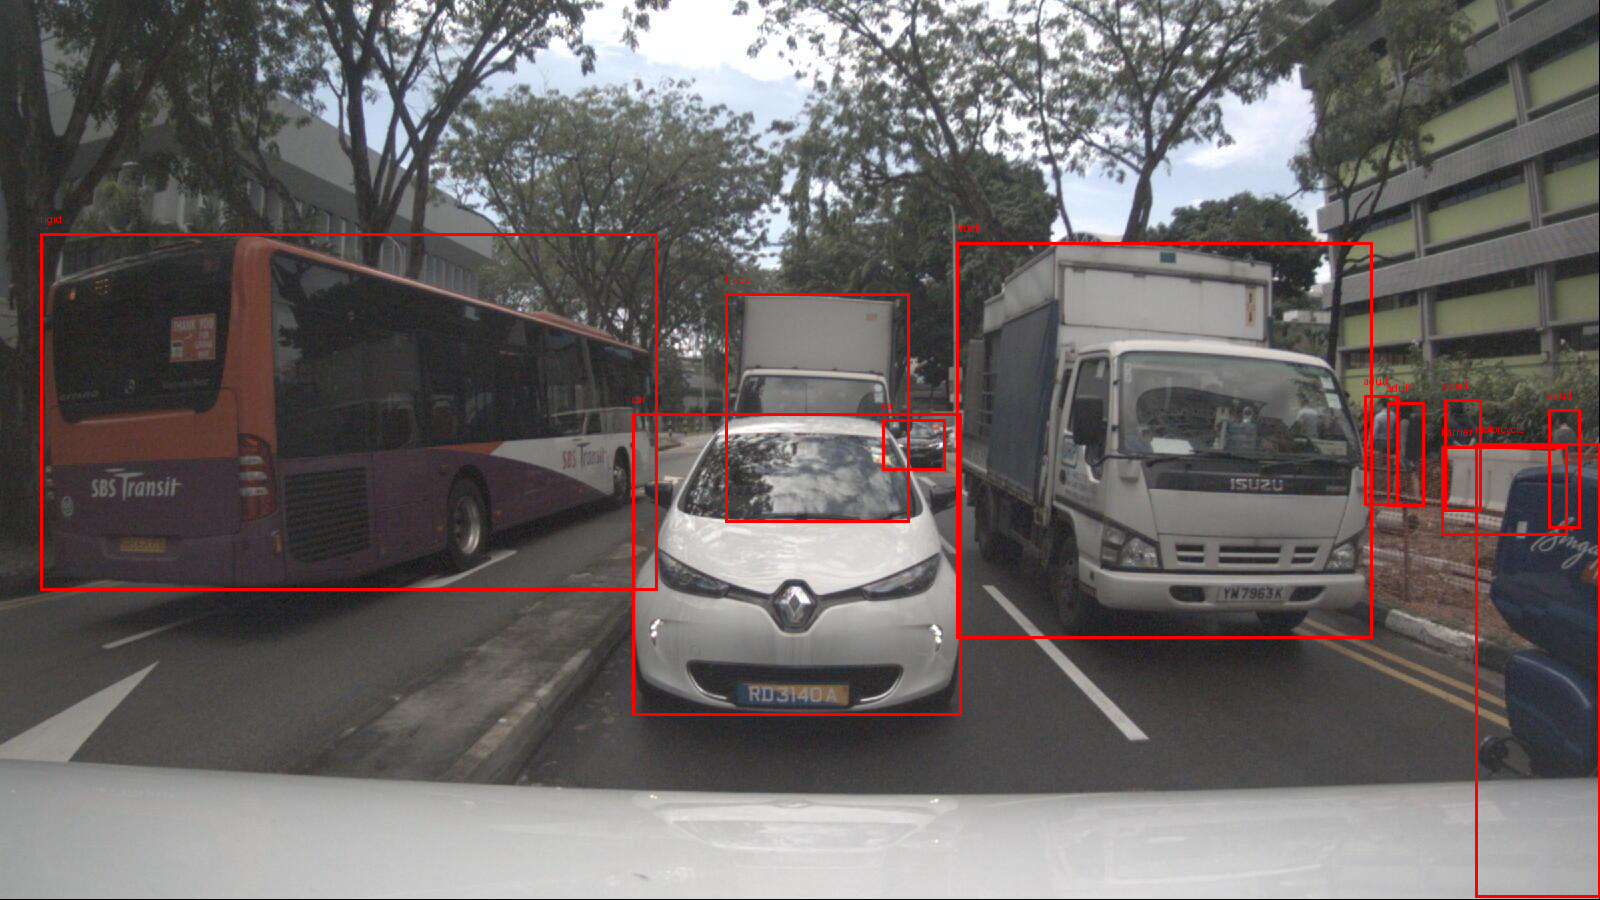

In [64]:
from PIL import Image, ImageDraw

file_df = merged_df[merged_df.filename == merged_df.filename[0]]

# Load the image
image_path = file_df['filename'][0]
image = Image.open(image_path)
draw = ImageDraw.Draw(image)


def write_bb_and_label(row, draw):
    # Draw the bounding box on the image
    draw.rectangle(row['bbox'], outline='red', width=3)

    # Add a label on top of the bounding box
    label = row['name'].split('.')[-1]  # Example label, this can be replaced with actual labels from the dataset
    # We will place the label at the top-left corner of the bounding box
    label_position = (row['bbox'][0], row['bbox'][1] - 20)  # 20 pixels above the top left corner of the bounding box
    # Draw the label
    draw.text(label_position, label, fill='red')


file_df.apply(lambda x: write_bb_and_label(x, draw), axis=1)



# Save the image with bounding box
output_path = 'image_with_bbox.png'
# image.save(output_path)
# output_path
image